## Clasificador de Noticias Argentinas 

In [23]:
import pandas as pd

df = pd.read_excel('../../res/tp1/Noticias_argentinas.xlsx', sheet_name='aa_bayes')

In [24]:
# Nos quedamos con los atributos de interes

df = df[["titular", "categoria"]]

# removemos las categorias que no necesitamos ('Destacadas', 'Noticias Destacadas')


df.head()

,titular,categoria
0,Trabajadores del Buenos Aires Design cortan la...,Nacional
1,La boda del gobernador Gerardo Morales: tapas ...,Nacional
2,Cumbre del G20: qué calles estarán cortadas y ...,Nacional
3,Una fractura que confirma la candidatura de Cr...,Nacional
4,Infierno grande: ola de divorcios en un pueblo...,Nacional


In [25]:
df = df.loc[df['categoria'].isin(("Nacional", "Economia", "Internacional", "Deportes", "Salud", "Ciencia y Tecnologia", "Entretenimiento"))]
df.head()
categories = df['categoria'].unique()
print(categories)


['Nacional' 'Deportes' 'Salud' 'Ciencia y Tecnologia' 'Entretenimiento'
 'Economia' 'Internacional']


In [26]:
df['categoria'].value_counts()

Nacional                3860
Ciencia y Tecnologia    3856
Deportes                3855
Entretenimiento         3850
Internacional           3850
Economia                3850
Salud                   3840
Name: categoria, dtype: int64

In [27]:
from sklearn.model_selection import train_test_split

# Separar los datos en datos de entrenamiento y testeo
train, test = train_test_split(df, test_size=0.2)
train.head()
test.head()

,titular,categoria
24408,La desgarradora historia detrás del femicidio ...,Nacional
2549,Habló la mejor amiga de Alicia Muñiz: 'Ella lo...,Entretenimiento
17244,Más de 600 mil niños todavía no se vacunaron c...,Salud
16289,Ahora podrá tener WhatsApp en dos dispositivos...,Ciencia y Tecnologia
16784,Matías Martin confirmó la desvinculación de Ca...,Entretenimiento


In [28]:
import re # regular expressions

def split_and_sanitize(title):
    words = title.split()  # se separan las palabras según espacios (quita todos los espacios)
    words = list(map(lambda x: re.sub("[^\w\s]", '', x).lower(), words))  # reemplazo de símbolos por ningún caracter
    words = list(filter(lambda x: len(x) > 1 and x not in ['en', 'la', 'el', 'los', 'lo', 'las', 'un', 'una', 'unos', 'unas', 'de', 'del', 'se', 'para', 'que'], words))
    return words

# Crear diccionario de categorias con diccionarios vacios para las palabras de los titulares
categories_word_appearances = { cat : {} for cat in categories }

# Contamos las apariciones de las palabras en las distintas categorías
for i in range(len(train)):
    row = train.iloc[i]
    category = row['categoria']
    title = row['titular']
    words = split_and_sanitize(title)

    for word in words:
        if word in categories_word_appearances[category]:
            categories_word_appearances[category][word] += 1
        else:
            categories_word_appearances[category][word] = 1

In [29]:
print(categories_word_appearances['Entretenimiento']['pampita'])
print(words[0:10])

61
['corrientes', 'logró', 'cobertura', 'total', 'campaña', 'sarampión', 'rubéola']


In [30]:
# Calcular probabilidades de las clases P(category) para el conjunto de entrenamiento

category_relative_freq = train['categoria'].value_counts() / len(train)  # P(category)
print(category_relative_freq)

# Calcular las probabilidades condicionales P(word | category)
word_relative_frequencies = { cat : {} for cat in categories }
zero_probabilities = { cat : 0 for cat in categories }
for category in categories:
    word_appearances_sum = sum(categories_word_appearances[category].values())  # suma de todas las apariciones de todas las palabras de la categoría
    laplace_denominator = float(word_appearances_sum + len(categories_word_appearances[category].keys()))  # Por Laplace le sumo la cantidad de clases
    for word, word_count in categories_word_appearances[category].items():
        word_relative_frequencies[category][word] = (word_count + 1) / laplace_denominator
    
    zero_probabilities[category] = 1 / laplace_denominator  # Ajuste de Laplace cuando no existe la palabra en la categoría

# Objetivo final:
#   P (category | [word])
# = P ([word] | category) * P (category)      ##  / P ([word])
# = prod(P (word | category)) * P (category)

Economia                0.145261
Ciencia y Tecnologia    0.143639
Salud                   0.143314
Deportes                0.142758
Nacional                0.142155
Internacional           0.141970
Entretenimiento         0.140903
Name: categoria, dtype: float64


In [31]:
print(word_relative_frequencies['Entretenimiento']['pampita'])
print(sum(word_relative_frequencies['Entretenimiento'].values()))

0.00187657011410757
0.999999999999975


In [32]:
def classify(title):
    words = split_and_sanitize(title)
    vs = {}
    for category in categories:
        v = category_relative_freq.loc[category]  # P(category)
        for word in words:
            if word in word_relative_frequencies[category]:
                v *= word_relative_frequencies[category][word]  # P(word | category)
            else:
                v *= zero_probabilities[category]  # Laplace
        vs[category] = v
    mx = (None, 0)  # A partir de esta línea se elije el valor máximo. Más adelante se convierte a probabilidad
    for category, v in vs.items():
        if v > mx[1]:
            mx = (category, v)
    return mx[0]

noticia = 'Pampita fue a la mesa de Mirtha'
print(f"La noticia '{noticia}' pertenece a {classify(noticia)}")
noticia = 'Messi metió un gol'
print(f"La noticia '{noticia}' pertenece a {classify(noticia)}")
noticia = 'Apple lanzó un nuevo iPhone'
print(f"La noticia '{noticia}' pertenece a {classify(noticia)}")

La noticia 'Pampita fue a la mesa de Mirtha' pertenece a Entretenimiento
La noticia 'Messi metió un gol' pertenece a Deportes
La noticia 'Apple lanzó un nuevo iPhone' pertenece a Ciencia y Tecnologia


<AxesSubplot:>

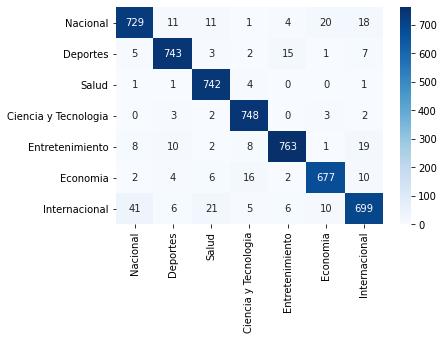

In [33]:
import seaborn as sns

# Armado de matriz de confusión (filas: valores reales; columnas: valores predictivos)
confusion_matrix = { cat : {} for cat in categories }
columns = []
for key in confusion_matrix.keys():
    columns.append(key)
    confusion_matrix[key] = { cat : 0 for cat in categories } # {'Deportes': {'Deportes': 700, 'Entretenimiento': 3, ...}, ...}

for i in range(len(test)):
    row = test.iloc[i]
    category = row['categoria']
    title = row['titular']
    result = classify(title)
    confusion_matrix[category][result] += 1

confusion_df = { key : list(confusion_matrix[key].values()) for key in confusion_matrix.keys() }
confusion_df = pd.DataFrame.from_dict(confusion_df, orient='index', columns=columns)

sns.heatmap(confusion_df, annot=True, cmap='Blues', fmt='g')

In [34]:
import numpy as np
   
# Calculamos las metricas para cada categoria
category_metrics = { cat : {'tp': 0, 'tn': 0, 'fp': 0, 'fn': 0, 'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0} for cat in categories }

for i, category in enumerate(categories):
    
    # Metricas simples
    tp = confusion_df.iloc[i,i]
    tn = sum(np.diag(confusion_df)) - tp
    fn = sum(confusion_df.loc[category]) - tp
    fp = sum(confusion_df[category]) - tp
    
    category_metrics[category]['tp'] = tp
    category_metrics[category]['tn'] = tn
    category_metrics[category]['fp'] = fp
    category_metrics[category]['fn'] = fn
    
    # Metricas compuestas
    category_metrics[category]['accuracy'] = (tp + tn) / (tp + tn + fn + fp)
    category_metrics[category]['precision'] = tp / (tp + fp)
    category_metrics[category]['recall'] = tp / (tp + fn)
    category_metrics[category]['f1'] = (2 * category_metrics[category]['precision'] * category_metrics[category]['recall']) / (category_metrics[category]['precision'] + category_metrics[category]['recall'])

metric_cols = ['tp', 'tn', 'fp', 'fn', 'accuracy', 'precision', 'recall', 'f1']
metrics_df = { key : list(category_metrics[key].values()) for key in category_metrics.keys() }    
metrics_df = pd.DataFrame.from_dict(category_metrics, orient='index', columns=metric_cols)

metrics_df

,tp,tn,fp,fn,accuracy,precision,recall,f1
Nacional,729,4372,57,65,0.976642,0.927481,0.918136,0.922785
Deportes,743,4358,35,33,0.986845,0.955013,0.957474,0.956242
Salud,742,4359,45,7,0.989909,0.942821,0.990654,0.966146
Ciencia y Tecnologia,748,4353,36,10,0.991063,0.954082,0.986807,0.970169
Entretenimiento,763,4338,27,48,0.985510,0.965823,0.940814,0.953154
Economia,677,4424,35,40,0.985510,0.950843,0.944212,0.947516
Internacional,699,4402,57,89,0.972175,0.924603,0.887056,0.905440


In [35]:
# Calcular probabilidades para la curva ROC
def classify_with_prob(title):
    words = split_and_sanitize(title)
    
    vs = {}
    denom = 0  # P([word]) == P(word1, word2, ...)
               # = P(word1, word2, ... | category1) * P(category1) + P(word1, word2, ... | category2) * P(category2) + ... 
               # = sum(P(word1 | category_i) * P(word2 | category_i) * ... * P(category_i))
    for category in categories:
        v = category_relative_freq.loc[category]
        
        for word in words:
            if word in word_relative_frequencies[category]:
                v *= word_relative_frequencies[category][word]  # prod(P(word_i | category)) * P(category)
            else:
                v *= zero_probabilities[category]
                
        vs[category] = v
        denom += v
        
    for k in vs.keys():
        vs[k] /= denom

    return vs

In [36]:
print(classify_with_prob("Messi metió ocho goles"))
print(sum(classify_with_prob("Messi metió ocho goles").values()))

{'Nacional': 0.0015324328736724595, 'Deportes': 0.9958389112249316, 'Salud': 5.887552152326251e-05, 'Ciencia y Tecnologia': 0.0004374367995542418, 'Entretenimiento': 0.0005573936202338033, 'Economia': 0.00032520179933310817, 'Internacional': 0.0012497481607515082}
1.0


In [37]:
import matplotlib.pyplot as plt

#classification_probs = []
u = [0.1 * x for x in range(1, 10)]

category_metrics = { cat : { threshold : {'tp': 0, 'tn': 0, 'fp': 0, 'fn': 0} for threshold in u} for cat in categories }
titular_classifications = {} # {'Messi metió un gol': {'categoria_real': 'Deportes', prob_Deportes: 0.99, prob_Salud: 0.001, ... }, ...}

# Itero por el dataset de prueba y calculo las probabilidades para cada titular en cada categoría
for i in range(len(test)):
    row = test.iloc[i]
    fmt = {'categoria_real': row['categoria']}
    category = row['categoria']
    title = row['titular']
    vs = classify_with_prob(title)
    
    for cat, v in vs.items():
        fmt[f"prob_{cat}"] = v
    titular_classifications[row['titular']] = fmt

for category in categories:
    # Obtengo los titulares que coinciden con la categoría analizada y se compara la probabilidad de esa categoría con el umbral
    records = test.query(f"categoria == '{category}'")
    for index, record in records.iterrows():
        prob = titular_classifications[record['titular']][f"prob_{category}"]
        for threshold in u:
            if prob >= threshold:
                category_metrics[category][threshold]['tp'] += 1
            else:
                category_metrics[category][threshold]['fn'] += 1

    # Obtengo los titulares que no coinciden con la categoría analizada y se compara la probabilidad de la categoría real con el umbral
    records = test.query(f"categoria != '{category}'")
    for index, record in records.iterrows():
        real_category = titular_classifications[record['titular']]['categoria_real']
        prob = titular_classifications[record['titular']][f"prob_{real_category}"]
        for threshold in u:
            if prob >= threshold:
                category_metrics[category][threshold]['fp'] += 1
            else:
                category_metrics[category][threshold]['tn'] += 1
    
# print(category_metrics)

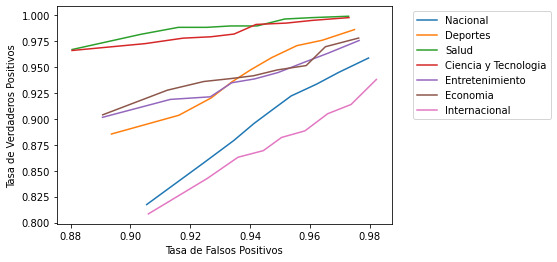

In [38]:
for c, thresholds in category_metrics.items():
    x = []
    y = []
    for threshold, values in thresholds.items():
        TPR = float(values['tp']) / (values['tp'] + values['fn'])  # Tasa de Verdaderos positivos
        FPR = float(values['fp']) / (values['fp'] + values['tn'])  # Tasa de Falsos positivos
        x.append(FPR)
        y.append(TPR)
    plt.plot(x,y, label=c)
# plt.xlim([0, 1])
# plt.ylim([0, 1])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.legend(loc="best", bbox_to_anchor=(1.05, 1))
plt.show()